In [1]:
import json
import os
import numpy as np

In [2]:
def import_metrics_json(models_path, run_num):
    """
    Looks in {models_path}/{run_num}/metrics.json and returns the contents as a
    Python dictionary. Returns None if the path does not exist.
    """
    path = os.path.join(models_path, str(run_num), "metrics.json")
    if not os.path.exists(path):
        return None
    with open(path, "r") as f:
        return json.load(f)

In [3]:
def get_best_metric(models_path, metric_name, reduce_func, compare_func):
    """
    Given the path to a set of runs, determines the run with the best metric value,
    for the given `metric_name`. For each run, the function `reduce_func` must take
    the array of all values for that metric and return a (scalar) value to use for
    comparison. The best metric value is determined by `metric_compare_func`, which
    must take in two arguments, and return whether or not the _first_ one is better.
    Returns the number of the run, the value associated with that run, and a dict of
    all the values used for comparison.
    """
    # Get the metrics, ignoring empty or nonexistent metrics.json files
    metrics = {run_num : import_metrics_json(models_path, run_num) for run_num in os.listdir(models_path)}
    metrics = {key : val for key, val in metrics.items() if val}  # Remove empties
    
    # Get the best value
    best_run, best_val, all_vals = None, None, {}
    for run_num in metrics.keys():
        try:
            val = reduce_func(metrics[run_num][metric_name]["values"])
            all_vals[run_num] = val
            if best_val is None or compare_func(val, best_val):
                best_val, best_run = val, run_num
        except Exception:
            print("Warning: Was not able to compute values for run %s" % run_num)
            continue
    return best_run, best_val, all_vals

In [4]:
def get_best_metric_at_best_epoch(models_path, metric_name, reduce_func, compare_func):
    """
    Given the path to a set of runs, determines the run with the best metric value,
    for the given `metric_name`. For each run, the function `reduce_func` must take
    the array of all values for that metric and return a (scalar) value FOR EACH
    SUBARRAY/VALUE in the value array to use for comparison. The best metric value
    is determined by `metric_compare_func`, which must take in two arguments, and
    return whether or not the _first_ one is better.
    Returns the number of the run, the (one-indexed) number of the epch, the value
    associated with that run and epoch, and a dict of all the values used for
    comparison (mapping pair of run number and epoch number to value).
    """
    # Get the metrics, ignoring empty or nonexistent metrics.json files
    metrics = {run_num : import_metrics_json(models_path, run_num) for run_num in os.listdir(models_path)}
    metrics = {key : val for key, val in metrics.items() if val}  # Remove empties
    
    # Get the best value
    best_run, best_epoch, best_val, all_vals = None, None, None, {}
    for run_num in metrics.keys():
        try:
            # Find the best epoch within that run
            best_epoch_in_run, best_val_in_run = None, None
            for i, subarr in enumerate(metrics[run_num][metric_name]["values"]):
                val = reduce_func(subarr)
                if best_val_in_run is None or compare_func(val, best_val_in_run):
                    best_epoch_in_run, best_val_in_run = i + 1, val
            all_vals[(run_num, best_epoch_in_run)] = best_val_in_run
            
            # If the best value in the best epoch of the run is best so far, update
            if best_val is None or compare_func(best_val_in_run, best_val):
                best_run, best_epoch, best_val = run_num, best_epoch_in_run, best_val_in_run
        except Exception:
            print("Warning: Was not able to compute values for run %s" % run_num)
            continue
    return best_run, best_epoch, best_val, all_vals

In [6]:
def print_validation_profile_and_prior_losses(condition):
    models_path = "/users/amtseng/att_priors/models/trained_models/profile_models/%s/" % condition
    
    print("Best profile loss overall:")
    best_run, best_epoch, best_val, all_vals = get_best_metric_at_best_epoch(
        models_path,
        "val_prof_corr_losses",
        lambda values: np.mean(values),
        lambda x, y: x < y
    )
    print("\tBest run: %s" % best_run)
    print("\tBest epoch in run: %d" % best_epoch)
    print("\tAssociated value: %s" % best_val)
    
    print("Best epoch in each run:")
    for key in sorted(all_vals.keys(), key=lambda p: int(p[0])):
        print("\tRun %s, epoch %d: %6.2f" % (key[0], key[1], all_vals[key]))
        
    print("All validation profile and prior losses:")
    for key in sorted(all_vals.keys(), key=lambda p: int(p[0])):
        print(key[0])
        metrics = import_metrics_json(models_path, key[0])
        print("\t" + " ".join(["%6.2f" % i for i in np.mean(metrics["train_prof_corr_losses"]["values"], axis=1)]))
        print("\t" + " ".join(["%6.2f" % i for i in np.mean(metrics["val_prof_corr_losses"]["values"], axis=1)]))
        print("\t" + " ".join(["%6.4f" % i for i in np.mean(metrics["val_att_losses"]["values"], axis=1)]))
    return all_vals

In [74]:
noprior_vals = print_validation_profile_and_prior_losses("E2F6")

Best profile loss overall:
	Best run: 29
	Best epoch in run: 9
	Associated value: 149.85964560130284
Best epoch in each run:
	Run 1, epoch 10: 151.35
	Run 2, epoch 8: 150.94
	Run 3, epoch 10: 150.32
	Run 4, epoch 10: 150.36
	Run 5, epoch 6: 150.94
	Run 6, epoch 9: 150.07
	Run 7, epoch 7: 149.92
	Run 8, epoch 9: 150.41
	Run 9, epoch 10: 151.67
	Run 10, epoch 9: 150.27
	Run 11, epoch 7: 150.20
	Run 12, epoch 10: 150.22
	Run 13, epoch 10: 150.59
	Run 14, epoch 10: 150.48
	Run 15, epoch 9: 150.67
	Run 16, epoch 8: 150.92
	Run 17, epoch 10: 150.85
	Run 18, epoch 10: 150.90
	Run 19, epoch 8: 149.96
	Run 20, epoch 8: 150.74
	Run 21, epoch 10: 150.52
	Run 22, epoch 9: 150.92
	Run 23, epoch 8: 151.08
	Run 24, epoch 10: 151.33
	Run 25, epoch 10: 150.37
	Run 26, epoch 10: 150.69
	Run 27, epoch 8: 151.86
	Run 28, epoch 10: 152.33
	Run 29, epoch 9: 149.86
	Run 30, epoch 9: 152.01
	Run 31, epoch 10: 150.59
	Run 32, epoch 4: 153.79
All validation profile and prior losses:
1
	173.45 166.75 161.79 159.

In [79]:
prior_vals = print_validation_profile_and_prior_losses("E2F6_prior")

Best profile loss overall:
	Best run: 15
	Best epoch in run: 9
	Associated value: 150.18527179294162
Best epoch in each run:
	Run 1, epoch 10: 152.39
	Run 2, epoch 8: 150.89
	Run 3, epoch 8: 150.37
	Run 4, epoch 10: 150.64
	Run 5, epoch 10: 151.76
	Run 6, epoch 10: 151.12
	Run 7, epoch 9: 151.45
	Run 8, epoch 9: 150.52
	Run 9, epoch 10: 151.97
	Run 10, epoch 8: 151.02
	Run 11, epoch 9: 150.84
	Run 12, epoch 10: 150.88
	Run 13, epoch 10: 151.95
	Run 14, epoch 9: 152.70
	Run 15, epoch 9: 150.19
	Run 16, epoch 4: 152.37
All validation profile and prior losses:
1
	173.87 168.51 166.20 164.45 162.57 161.08 159.90 158.99 158.39 157.79
	160.89 163.33 157.83 156.33 154.88 156.65 155.39 153.36 152.88 152.39
	0.1939 0.1605 0.1419 0.1217 0.1283 0.1578 0.1366 0.1368 0.1342 0.1315
2
	174.25 167.19 161.78 159.57 158.67 157.92 157.17 156.74 156.43 155.96
	159.79 155.19 152.83 152.35 151.61 151.42 151.53 150.89 151.52 151.34
	0.1624 0.1097 0.0950 0.0886 0.0875 0.0845 0.0830 0.0808 0.0849 0.0770
3
	174

In [81]:
["%s/model_ckpt_epoch_%d.pt" % (a, 10) for a, b in sorted(prior_vals.keys(), key=lambda p: int(p[0]))]

['1/model_ckpt_epoch_10.pt',
 '2/model_ckpt_epoch_10.pt',
 '3/model_ckpt_epoch_10.pt',
 '4/model_ckpt_epoch_10.pt',
 '5/model_ckpt_epoch_10.pt',
 '6/model_ckpt_epoch_10.pt',
 '7/model_ckpt_epoch_10.pt',
 '8/model_ckpt_epoch_10.pt',
 '9/model_ckpt_epoch_10.pt',
 '10/model_ckpt_epoch_10.pt',
 '11/model_ckpt_epoch_10.pt',
 '12/model_ckpt_epoch_10.pt',
 '13/model_ckpt_epoch_10.pt',
 '14/model_ckpt_epoch_10.pt',
 '15/model_ckpt_epoch_10.pt',
 '16/model_ckpt_epoch_10.pt']

In [10]:
import matplotlib.pyplot as plt
import scipy.stats

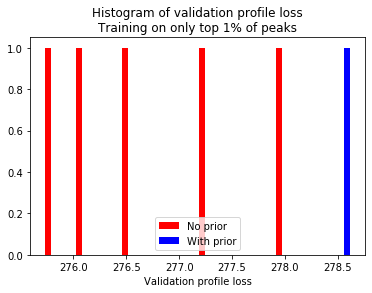

In [71]:
bin_num = 20
plt.figure()
plt.hist(
    [np.array(list(noprior_vals.values())), np.array(list(prior_vals.values()))],
    bin_num, histtype="bar",
    label=["No prior", "With prior"], color=["red", "blue"])
title = "Histogram of validation profile loss"
title += "\nTraining on only top 1% of peaks"
plt.title(title)
plt.xlabel("Validation profile loss")
plt.legend()

In [68]:
np_vals, p_vals = np.array(list(noprior_vals.values())), np.array(list(prior_vals.values()))
t, p = scipy.stats.ttest_ind(np_vals, p_vals)
print(t)
print(p / 2)

0.25600345785323875
0.39924238231685866
